# Experiment Tracking with MLFlow (GCP)

In this demo we will see how to use MLFlow for tracking experiments in GCP instead of locally. To do so, we need three pieces of our infrastructure:

1. Storage for our logged metrics and parameters.  
2. Storage for our logged artifacts and models.   
3. A server for running the MLFlow server, which is how our experiment runs actually get logged when we run our code.  

Up until now, we've used local file systems and sqlite for storage and our laptop for the server. In GCP we can use postgreSQL for our metrics and parameters, Google Cloud Storage (GCS) for our artifacts and models, and one of several different options for running our MLFlow server. For the server we can use a simple Google Compute Engine, which is basically a VM, where we install everything we need in order to run MLFlow on it. The problem with this is that this is not really portable/scalable because we are "physically" installing everything on a "machine", and so if we want to use the same environment somewhere else, we cannot do so easily. A better option is to use a container, along with container orchestration. For this, we have two main options: (1) Google Kubernetes Engine (GKE); or (2) Google Cloud Run. 

If we use GKE, we will need to worry about creating manifests and deployments for our pods, meaning that we need to worry more about the infrastructure itself, which can be painful. Instead, Google Cloud Run makes it easier by abstracting everything away and doing all of the orchestration for us, so let's go with that.



### Process We Need To Follow

The general process we need to go through in order to get this to work is:

1. Set up our account with GCP.  
2. Set up gcloud, the GCP CLI, on our laptop.  
3. Create a project on GCP that we will use for our class project.  
4. Set up our SQL instance.   
5. Set up our storage bucket.  
6. Set up a Docker repository for our Docker image that we will be running.  
7. Set up a Service Account.  
8. Set up our secrets.  
9. Create and build our Docker image.  
10. Deploy using Google Cloud Run.   
11. Test it out by using MLFlow from our laptop.  

For many of these things, we could use the GCP Console, but instead we will use gcloud commands which is easier to reproduce later. I used [this](https://medium.com/@andrevargas22/how-to-launch-an-mlflow-server-with-continuous-deployment-on-gcp-in-minutes-7d3a29feff88) tutorial to get mine running, most of which I've reproduced below with additional details.

### Install gcloud and Create a Project

First we must install the GCP CLI [here](https://cloud.google.com/sdk/docs/install-sdk).

To first configure things we can run `gcloud init`.

Next, create a project and link a billing account to it. We can do this within the Google Cloud Console in the browser following [these](https://developers.google.com/workspace/guides/create-project) instructions. Once a project is created and the billing account is linked we can move on to the next steps.

### SQL

For SQL we need to do three steps: (1) create an instance of postgreSQL; (2) create a user; and (3) create the database that will be used.

To create the instance, use the below, and give it a name. We can use the us-west2 region for this, as it's the closest to us I think. And we can use the smallest tier since we do not need much. All settings can be found [here](https://cloud.google.com/sql/docs/postgres/instance-settings).

```
gcloud sql instances create <instance-name> \
--database-version=POSTGRES_15 \
--region=us-west2 \
--tier=db-f1-micro \
--storage-type=HDD \
--storage-size=10GB \
--authorized-networks=0.0.0.0/0
```

Next, we will need to create a user and password so we can access the instance.

```
gcloud sql users create <username> \
--instance=<instance-name> \
--password=<password>
```

And lastly, we should create a database.

`gcloud sql databases create <db-name> --instance=<instance-name>`

### GCS

Creating a bucket is very simple. 

`gcloud storage buckets create gs://<bucket-name>`

Within this bucket we will need a folder called `mlruns/` which mlflow will be using to store artifacts. You can create this bucket within the console.

### Repository

We need a repository for the mlflow image that we will be creating later. We can create our own repo using the following:

```
gcloud artifacts repositories create <repo-name> \
--location=us-west2 \
--repository-format=docker
```

### Service Account

A service account is an account that is not tied to a personal user account. We need the service account, and then we need to assign to our service account different *roles* so that our MLFlow application can access the different GCP services that the application is using. We can easily create a service account using

`gcloud iam service-accounts create <acct-name>`

From here, we need to grant different roles to the service account. First, we need to know what our project id is, which we can find using

`gcloud config get-value project`


Then we can grant the roles by running the following command, separately, for each role that we need:

`gcloud projects add-iam-policy-binding <project-id> --member='serviceAccount:<acct-name>@<project-id>.iam.gserviceaccount.com' --role='roles/<role-name>'`

For `<role-name>`, we will need:

- cloudsql.editor  
- storage.objectAdmin  
- secretmanager.secretAccessor  
- artifactregistry.admin  
- clouddeploy.serviceAgent  
- cloudfunctions.admin


### Secrets

In order to access our cloud sql instance and storage bucket we will create secrets. First, we need to create a set of keys for our service account:

`gcloud iam service-accounts keys create sa-private-key.json --iam-account=<acct-name>@<project-id>.iam.gserviceaccount.com`

This will create a json file with a private_key value. This is not meant to be shared. We are going to now create a secret, called access_keys, for this private key. Essentially this secret will contain the contents of the json file we just created above.

`gcloud secrets create access_keys --data-file=sa-private-key.json`

From here we need a secret for our cloud sql instance. To do this we will need the ip address for our sql instance, which we can get by running:

`gcloud sql instances describe <instance-name>`

Then we can use the ip address in the following commands to create the secret:

`gcloud secrets create database_url`  

```
echo -n "postgresql://<username>:<password>@<ip>/<db-name>" | \
    gcloud secrets versions add database_url --data-file=-
```

These command will first create an empty secret called database_url, and then add to that secret the url for the database. `--data-file=-` just means to use the piped input, whereas before we used the contents of sa-private-key.json when we created our access_keys secret.

Next, we will do the same for our storage bucket.

`gcloud secrets create bucket_url`  

```
echo -n "gs://<bucket-name>/mlruns" | \
    gcloud secrets versions add bucket_url --data-file=-
```

We are essentially doing the same thing as with our database_url secret, just adding the bucket url to the bucket_url secret, with the folder for where our artifacts from our experiments will be stored.

It may seem strange to make these secret URLs, and for right now they're not really necessary, but later on when we put all of this on Github we won't want those URLs hard-coded anywhere.

### Docker Image

Now we will need to create our application. We need a docker image for running MLFlow server. For this we can create a new Dockerfile, a requirements.txt file for dependencies, and a shell script for running MLFlow server (rather than including it in the Dockerfile directly).

First, the requirements.txt file can be bare bones since its only responsibility is running the MLFlow server. It only needs the following libraries:

setuptools  
mlflow==2.15.1  
psycopg2-binary==2.9.9 # for postgres  
google-cloud-storage==2.18.2  

Next, the Dockerfile needs to be created. Below is one that works, but feel free to modify it.

FROM python:3.12-slim

WORKDIR /

COPY requirements.txt requirements.txt   
COPY server.sh server.sh

ENV GOOGLE_APPLICATION_CREDENTIALS='./secrets/credentials'

RUN pip install --upgrade pip && pip install -r requirements.txt

EXPOSE 8080

RUN chmod +x server.sh

ENTRYPOINT ["./server.sh"]


And lastly, here is the server shell script:

#!/bin/bash  

mlflow db upgrade $POSTGRESQL_URL
mlflow server \
  --host 0.0.0.0 \
  --port 8080 \
  --backend-store-uri $POSTGRESQL_URL \
  --artifacts-destination $STORAGE_URL


Ok, now we need to build the Docker image and push it to our repository that we created earlier. To do so we first must run 

`gcloud auth configure-docker us-west2-docker.pkg.dev`

This allows Docker to push to Google Cloud's artifact registry. If we look in our ~/.docker/config.json file we will see changes were made. Now, Docker will automatically push to the repository that has host name us-west2-docker.pkg.dev, and will authenticate using our gcloud credentials. Now, we can build and push the image, giving it a tag, such as v1:

`docker build --platform linux/amd64 -t "us-west2-docker.pkg.dev/<project-id>/<repo-name>/mlflow:<tag>" .`

`docker push "us-west2-docker.pkg.dev/<project-id>/<repo-name>/mlflow:<tag>"`

If we have issues with this, we can also simply use Google's own build command:  

`gcloud builds submit --tag us-west2-docker.pkg.dev/<project-id>/<repo-name>/mlflow:<tag>`

If you first get an error about a bucket, you can try enabling the Compute Engine API:

`gcloud services enable compute.googleapis.com`


And, if not already done, we might need to enable Cloud Run:  
`gcloud services enable run.googleapis.com`

### Google Cloud Run

Now that our image has been built, we need to run it with Google Cloud Run using the following:

```
gcloud run deploy "<service-name>" \
          --image "<image-name>" \
          --region "us-west2" \
          --service-account "<acct-name>" \
          --update-secrets=/secrets/credentials=access_keys:latest \
          --update-secrets=POSTGRESQL_URL=database_url:latest \
          --update-secrets=STORAGE_URL=bucket_url:latest \
          --memory 2Gi \
          --allow-unauthenticated \
          --port 8080
```

We can provide whatever name we want for `<service-name>`, pass the image name that we created when we built the image in the previous step. We also specify the region, the service account name, memory, and port. We use --allow-unauthenticated to allow unauthenticated access to the application. Now, let's describe what's happening with the three --update-secrets lines. Each of these lines is simply specifying secrets to wither mount or set as environment variables within the running application. 

Firstly, `--update-secrets=/secrets/credentials=access_keys:latest` is mounting the latest version of the access_keys secret within a file called credentials that sits in the secrets/ folder. 

Secondly, `--update-secrets=POSTGRESQL_URL=database_url:latest` is setting the POSTGRESQL_URL environment variable to the latest version of the database_url secret.

Lastly, `--update-secrets=STORAGE_URL=bucket_url:latest` is setting the STORAGE_URL environment variable to the latest version of the database_url secret.

Hopefully, this will run without errors. WE can go to console, under Cloud Run, to see the progress. If we click on the service, we can check the logs to see the progress, error messages, etc..

![Screenshot 2024-09-11 at 12.37.12 PM.png](<attachment:Screenshot 2024-09-11 at 12.37.12 PM.png>)

If it is successful, we will see a green check next to the service. 

![Screenshot 2024-09-11 at 12.36.49 PM.png](<attachment:Screenshot 2024-09-11 at 12.36.49 PM.png>)

When we click on the service there is a URL for our running MLFlow Server. This is the URL that we will need in order to set the tracking URI for MLFlow on our laptops when we run our experiments.

![Screenshot 2024-09-11 at 12.37.22 PM.png](<attachment:Screenshot 2024-09-11 at 12.37.22 PM.png>)
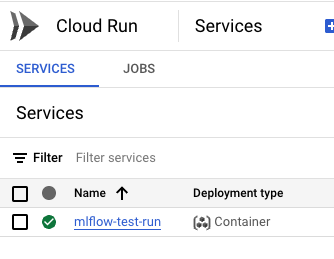
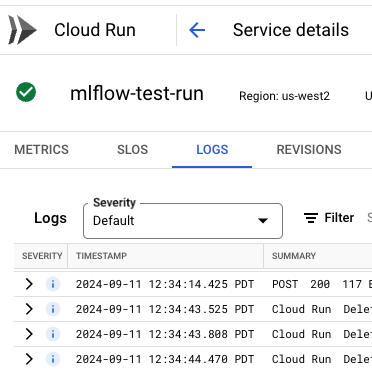
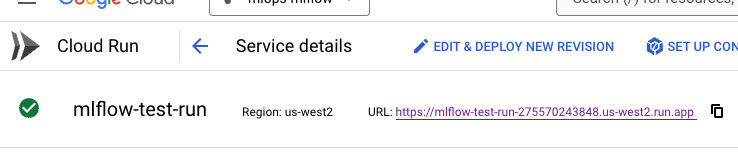

### Test MLFlow

To test our new MLFlow instance we can run some experiments from our Lab 2, after first replacing the tracking URI with the URL from Google Cloud Run. Luckily, you've done this before, so all you need to do is update one line of code and rerun some experiments.

# MLFlow in GCP Lab

## Overview

Using MLFlow locally on our laptops is useful only for classroom assignments and small personal/work projects. In a team environment, where results need to be shared with multiple data scientists, or where multiple data scientists are working on multiple projects, MLFlow should be set up so that all team members can access it.

## Goal

The goal of this lab is to get MLFlow running in GCP.

## Instructions

Use the instructions above to get MLFlow running in GCP using Google Cloud Run. Save all commands that were used, in order, in a separate file, for your own records and sanity. Do as much as possible on the command line, but it is ok if some things are done within the GCP Console - just keep notes of what you do in the conosle in case you need to repeat it later. 

Once you are successful, rerun the experiments that you ran from Lab 2, and register a final model, which we may deploy at a later date.

For grading purposes, I will check for completeness. Can I access the running instance of MLFlow and did you run the experiments and register the final model.

### Turning It In

In Canvas, submit the **URL for your running MLFlow instance**. I will check it the day after it is due, and as soon as your grade is posted you can delete it and any other services you might want to in order to avoid costs. From my billing report, it looks like Cloud SQL is the service that costs the most.

For grading I will be checking that the URL works, that experiments are run, and that a model is registered.